# A Tour of Apache Arrow

# Apache Arrow (History)

- Wes McKinney - "10 things I hate about pandas"
- Started around 2017
- Supported by Apache Software Foundation
     

# Apache Arrow (History)

The 10 (actually 11) things that are identified by Wec McKinney


    Internals too far from "the metal"
    No support for memory-mapped datasets
    Poor performance in database and file ingest / export
    Warty missing data support
    Lack of transparency into memory use, RAM management
    Weak support for categorical data
    Complex groupby operations awkward and slow
    Appending data to a DataFrame tedious and very costly
    Limited, non-extensible type metadata
    Eager evaluation model, no query planning
    "Slow", limited multicore algorithms for large datasets





# Apache Arrow (History)

The 10(actually 11) things that are identified by Wec McKinney


1. Internals too far from "the metal"
2. No support for memory-mapped datasets
3. ~~Poor performance in database and file ingest / export ~~
4. Warty missing data support
5. Lack of transparency into memory use, RAM management 
6. Weak support for categorical data
7. ~~Complex groupby operations awkward and slow ~~
8. ~~Appending data to a DataFrame tedious and very costly ~~
9. Limited, non-extensible type metadata
10. ~~Eager evaluation model, no query planning ~~
11. ~~"Slow", limited multicore algorithms for large datasets ~~







# Apache Arrow (Goals)

From: https://arrow.apache.org/docs/index.html

-  Development platform for in-memory analytics
-  Process and move data faster
-  Standardized language indepedent columnar format for flat and hierarchical data
-  Zero-copy shared memory and RPC-based data movement

# Apache Arrow (Goals)


 
![arrow](https://www.tutorialandexample.com/wp-content/uploads/2019/06/Introduction-to-Apache-Arrow.png)
     
Source: https://www.tutorialandexample.com/wp-content/uploads/2019/06/Introduction-to-Apache-Arrow.png

# Arrow Columnar Format

- Language agnostic in-memory data structure

- Data adjacency for sequential access
- Constant Random Access
- SIMD and vectorization friendly
- 'Pointer-Swizling' avoided resulting in zero-copy access in share memory

Source:
    https://arrow.apache.org/docs/format/Columnar.html

# PyArrow - Python Interface to Apache Arrow

- Memory Management
- Data Types 
- Compute Functions
- Numpy Integration
- Pandas Integration


# Memory management

-  Buffer 
-  Memory Pools
-  Input/Output Streams
-  On-Disk and Memory mapping Files

# Memory View and Buffer protocol

- Buffer protocol provides access to internal representation of memory
- MemoryView is a mechanism to access this internal mechanism from Python land.
- Let's look at some examples



In [1]:
# Example memory view

data = b'hello world'
m = memoryview(data)
m.obj


b'hello world'

In [2]:
print(f'{m[0]=}, {bytes(m[0:1])=}')

m[0]=104, bytes(m[0:1])=b'h'


# Memory View and Buffer protocol

In [3]:
# mutate memory view
data = bytearray('abcefgh', encoding='utf-8')
m = memoryview(data)
print(f'{m[-1]=}')

# some assignments
k = m[-3:]  # a slice of memory view is not new allocation
m[-1] = 72 # capital H

print(f'data after update = {data}')

print(bytes(k)) 


m[-1]=104
data after update = bytearray(b'abcefgH')
b'fgH'


# Arrow Buffers

In [4]:
# Pyarrow.buffer

import pyarrow as pa

data = b'abcdefgh'
data_buffer = pa.py_buffer(data)

z = data_buffer[-3:]
z.to_pybytes()

b'fgh'

# Controlling Memory Allocation

In [5]:
# Memory managed in Memory Pools

new_buffer = pa.allocate_buffer(4000)
print(pa.total_allocated_bytes())

new_buffer

#new_buffer[0] = None # Does not support assignment

4032


# Writing/Reading To/From Buffers

In [6]:
# Reading/Writing To/From In-Memory Buffer

write = pa.BufferOutputStream()
write.write(b'hello world')

# write.getvalue # Finalize output stream and return stream as buffer
buffer = write.getvalue()

print('Type of buffer=', type(buffer))

reader = pa.BufferReader(buffer)
reader.read_at(6, 5)

# write.write(b'hello world, again') # not writing possible once read


Type of buffer= <class 'pyarrow.lib.Buffer'>


b' world'

# Stream - Buffer Relationship

    Write action ===> OutputStream ===> Buffer


    Read action <==== InputStream <==== Buffer

The `streams` can be specialized (for example reading/writing custom data structure)


# Data Types and In-Memory Data Model

-  Columnar data structures = type meta-data + memory buffers
-  pyarrow.DataType
-  pyarrow.Schema - collections of pyarrow.DataType
-  pyarrow.Arrays - atomic, contiguous columnar data structures composed from arrow buffer objects
-  pyarrow.RecordBatch - collection of ArrayObjects of a particular schema
-  pyarrow.Table  - Each column consists of pyarrow.Array




# Supported Types (Richer than what you store in Pandas/Numpy)

-  Fixed-length primitives - number, floats, timestamp etc
-  Variable-lenght primitives (strings)
-  Nested-Types (list, struct, union)
-  Dictionary types ( we wont cover this)
  
 

# Primitive Types

In [7]:
# Primitive Types

print(pa.int32())
print(pa.float64())

sample_float = pa.scalar(100.0, type=pa.float64())
sample_str = pa.scalar("hello world", type=pa.string())

print(f'{sample_float=}, \n{sample_str=}')

int32
double
sample_float=<pyarrow.DoubleScalar: 100.0>, 
sample_str=<pyarrow.StringScalar: 'hello world'>


# Composing Primitive Types to Define Fields

In [8]:
### Types used to define schema (metadata)

f1 = pa.field('country_count', pa.int32())
f2 = pa.field('price', pa.float64())

print(f'{f1=}, \n{f2=}')


f1=pyarrow.Field<country_count: int32>, 
f2=pyarrow.Field<price: double>


# Compose collection of fields into structs

In [9]:

f1 = pa.field('security_id', pa.int32())
f2 = pa.field('price', pa.float64())
f3 = pa.field('data_date', pa.date64())

new_struct =  pa.struct([f1, f2, f3])

new_struct


StructType(struct<security_id: int32, price: double, data_date: date64[ms]>)

# Arrays of Primitives/Structs

In [10]:

x = pa.array([1.0, 2.0, 3.0, 4.0], type=pa.float64())
y = pa.array(['sec1', 'sec2', 'sec3', 'sec4'], type=pa.string())

print(f'{x=} \n{y=}')

x=<pyarrow.lib.DoubleArray object at 0x7ff9a4039d60>
[
  1,
  2,
  3,
  4
] 
y=<pyarrow.lib.StringArray object at 0x7ff9a4039e20>
[
  "sec1",
  "sec2",
  "sec3",
  "sec4"
]


# More examples of Arrays

In [11]:

int_arr = pa.array([100, 200, 300, None], type=pa.uint32())
print(f'{int_arr=}')

float_arr = pa.array([100.1, 200.0, 300.0, float('nan'), None])
print(f'{float_arr=}')

# check out the NULLs
print(f'{float_arr[-1]=}')

float_arr.null_count 

int_arr=<pyarrow.lib.UInt32Array object at 0x7ff9a4050400>
[
  100,
  200,
  300,
  null
]
float_arr=<pyarrow.lib.DoubleArray object at 0x7ff9a4050100>
[
  100.1,
  200,
  300,
  nan,
  null
]
float_arr[-1]=<pyarrow.DoubleScalar: None>


1

In [12]:
# Slicing is zero-copy operation, since Array's are readonly
float_arr[1:3]

[
  200,
  300
]

# Missing Values (None)

In [13]:
# Dealings with Nones

x = int_arr[-1]

x.is_valid


False

# Composing Arrays into RecordBatch (like a Frame)

1. Define schema
2. Define arrays for each field in schema
3. Create a RecordBatch

In [14]:
# One can also define Schemas (to be used with Table/Record Batch)

schema = pa.schema([('security_id', pa.int32()), 
                    ('price', pa.float64()), 
                    ('data_data', pa.date64())])
schema

# schema's can also have nested structures



security_id: int32
price: double
data_data: date64[ms]

# Record Batches

- Collection of equal length array instances
- Remember (arrays are just contiguous elements of primitives, structs, unions)


In [15]:
# all elements should be of same length
data = [
    pa.array([1,2,3,4]),
    pa.array(['foo', 'bar','baz', None]),
    pa.array([True, None, False, True])
]
batch = pa.RecordBatch.from_arrays(data, ['f0', 'f1', 'f2'])

print(f'{batch.num_columns=}, \n{batch.num_rows=}, \n{batch.schema=}, \n\n{batch[1]=}')


batch.num_columns=3, 
batch.num_rows=4, 
batch.schema=f0: int64
f1: string
f2: bool, 

batch[1]=<pyarrow.lib.StringArray object at 0x7ff9a4050940>
[
  "foo",
  "bar",
  "baz",
  null
]


# Slicing into Record Batches

-  Zero-copy!

In [16]:
print(f'{batch[0:2][1] = }, {batch[0:2][0] = }')

batch[0:2][1] = <pyarrow.lib.StringArray object at 0x7ff9a4050be0>
[
  "foo",
  "bar"
], batch[0:2][0] = <pyarrow.lib.Int64Array object at 0x7ff9a4050be0>
[
  1,
  2
]


# Tables

- Grouping RecordBatches into one logical unit
- Needed so that record-batches arriving from different processes need not be copied/reorganized again
- Tables can also be concatenated

In [17]:
batches = [batch] * 2
table = pa.Table.from_batches(batches)

table[0]

[
  [
    1,
    2,
    3,
    4
  ],
  [
    1,
    2,
    3,
    4
  ]
]

# Things we did not cover

1. Categorical Types
2. Union/Structs/Nested Data structures

# What does Zero-Copy mean?

### Typical Transfer of Data (between boundaries)

Object -> Serialize (to Bytes) -> Network/Process/DataStructure boundary -> Deserialize(from Bytes) -> Object

### With Zero-Copy

Bytes -> Serialize (no-op) -> Network/Process/DataStructure boundary -> Deserialize -> Bytes (no-op)

# Numpy Integration - Numpy -> Arrow

- Conversion support limited to primitive types

In [20]:
import numpy as np
a = np.arange(10)
a

arrow = pa.Array.from_pandas(a)
arrow

# zero-copy (a view is returned)
a[-1] = 100
arrow


[
  0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  100
]

# Numpy Integration - Numpy -> Arrow

- Not always a zero-copy

In [25]:
a = np.arange(10)
a

arrow = pa.Array.from_pandas([[a]])
arrow
a[-1]=100
arrow


[
  [
    [
      0,
      1,
      2,
      3,
      4,
      5,
      6,
      7,
      8,
      9
    ]
  ]
]

# Numpy Integration - Arrow -> Numpy

- Conversion support limited to primitive types (better to just use from_pandas)

In [29]:
arrow = pa.Array.from_pandas(a)
a = arrow.to_numpy()
a
a.flags.writeable
#a[-1]=200  # not possible, since arrow sets num

False

# Pandas Integration

- Lots of conditions around zero-copy conversion
- More information of datatype mapping (https://arrow.apache.org/docs/python/pandas.html)

In [33]:
import pandas as pd
df = pd.DataFrame(
    data=dict(a=[0.1, 0.2, 0.3], 
              b=["test", None, "test"],
              c=["foo", "bar", "baz"],
))

arrow = pa.RecordBatch.from_pandas(df)
arrow[0]

[
  0.1,
  0.2,
  0.3
]

# Zero-Copy Gotchas

In [34]:
df = pd.DataFrame(data=dict(a=[0.1, 0.2, 0.3], 
                            b=["test", None, "test"],
                            c=["foo", "bar", "baz"]))

x = pa.RecordBatch.from_pandas(df)
df.iloc[-1]=[100, 'change', "foo"]
print(f'{x[0]=}, {x[1]=}, {x[2]=}')


x[0]=<pyarrow.lib.DoubleArray object at 0x7ff9a3f96b80>
[
  0.1,
  0.2,
  100
], x[1]=<pyarrow.lib.StringArray object at 0x7ff9a3f96b80>
[
  "test",
  null,
  "test"
], x[2]=<pyarrow.lib.StringArray object at 0x7ff9a3f96b80>
[
  "foo",
  "bar",
  "baz"
]


# Frames(SF/Pandas) Vs Arrow Table

- Both needs columns to be of same length
- Columns (arrays in Arrow) can have nested types like struct etc (first class objects)
- Tables are read-only 
- Compact storage and other benefits when using Arrows
- Pandas has more support for analytical functions

# Compute Functions

In [35]:
import pyarrow.compute as pc
print(f'{ batch[0] = }\n')
a = pc.sum(batch[0])
print(f'{a = }')

b = pc.multiply(batch[0], batch[0])
print(f'{b = }')

print(f'{pc.add(batch[0], batch[0])=}')


 batch[0] = <pyarrow.lib.Int64Array object at 0x7ff9a3f96400>
[
  1,
  2,
  3,
  4
]

a = <pyarrow.Int64Scalar: 10>
b = <pyarrow.lib.Int64Array object at 0x7ff9a3f96be0>
[
  1,
  4,
  9,
  16
]
pc.add(batch[0], batch[0])=<pyarrow.lib.Int64Array object at 0x7ff9a3f96c40>
[
  2,
  4,
  6,
  8
]


# Compute Functions - Containment

In [36]:
print(f'{batch[0] = }\n')
print(f'{pc.equal(batch[0], 101)=}')

l = pc.SetLookupOptions(value_set=pa.array([101]))
print(f'{pc.is_in(batch[0], options=l) = }')

batch[0] = <pyarrow.lib.Int64Array object at 0x7ff9a3f96d60>
[
  1,
  2,
  3,
  4
]

pc.equal(batch[0], 101)=<pyarrow.lib.BooleanArray object at 0x7ff9a3f96400>
[
  false,
  false,
  false,
  false
]
pc.is_in(batch[0], options=l) = <pyarrow.lib.BooleanArray object at 0x7ff9a3f96d60>
[
  false,
  false,
  false,
  false
]


# Example Compute Function

In [37]:
# Example Calculating Returns

schema = pa.schema([('sec1', pa.float64()),
                    ('sec2', pa.float64()),
                    ('sec3', pa.float64())])

data = [pa.array([101, 102, 99]),
        pa.array([201, 200, 195]),
        pa.array([10, 20, 15])
       ]

batch = pa.RecordBatch.from_arrays(data, schema=schema)

def compute_returns(old, new):
        import pyarrow.compute as pc
        return pc.subtract(pc.divide(new, old),1)
        
returns = []
for i in range(batch.num_columns):
    price = batch[0]
    price1 = price[:-1]
    price2 = price[1:]
    z = compute_returns(price1, price2)
    returns.append(z)
    
returns_table = pa.RecordBatch.from_arrays(returns, schema=schema)

returns_table.to_pandas()

,sec1,sec2,sec3
0,0.009901,0.009901,0.009901
1,-0.029412,-0.029412,-0.029412


In [38]:
import pickle
import pyarrow
import matplotlib.pyplot as plt
import numpy as np
import timeit

def plot(data, labels, title, y_label):
    fig, ax = plt.subplots()
    #fig.set_size_inches(3.8, 2.7)

    bar_width = 0.15
    index = np.arange(len(labels))
    opacity = 0.6

    placement = 0
    for k, v in data.items():
        plt.bar(index+placement,
                v,
                bar_width,
                alpha=opacity, 
                #color='r', 
                label=k)
        placement += bar_width 
        

    plt.title(title, fontweight='bold')
    plt.ylabel(y_label, fontsize=10)
    plt.xticks(index + placement / len(list(data.keys())), labels, fontsize=10)
    plt.legend(fontsize=10, bbox_to_anchor=(1, 1))
    #plt.tight_layout()
    plt.yticks(fontsize=10)
    plt.savefig('plot-' + title + '.png', format='png')

In [39]:
import pandas as pd
def plot_test(filename, title, y_value, y_label):
    df = pd.read_csv(filename)
    df['method']=df['label'].map(lambda z: z.split('_')[0])
    df['rows']=df['label'].map(lambda z: tuple(map(int, z.split('_')[1:])))
    data = dict()
    df = df.sort_values('rows')
    for k, v2 in df.groupby('method'):
        g = v2.sort_index()[y_value].values.tolist()
        data[k]=g
    labels = []
    for k, _ in df.groupby('rows'):
        labels.append(f'({k[0]:_}, {k[1]})')
    #print(labels)
    #print(data)
    plot(data, labels, title, y_label)



# Performance in Multi-processing setup

# Performance Tests - 1 (Numpy Vs Arrow)

-  Create different arrays with plain floats
-  Find sum of each column in a multi-processed pool

-  Measure the time taken for serialization -> compute sum per column -> deserialization

In [40]:
# test1.py
# Data Set up routines
def get_numpy_array(rows, cols):
    data = np.array(list(np.array(list(range(0, rows))) for i in range(cols)))
    return data


def get_batch(rows, cols):
    data = get_numpy_array(rows, cols)
    batch = pa.RecordBatch.from_arrays(
        [pa.array(data[i]) for i in range(cols)],
        names=[f"{x}" for x in range(0, cols)],
    )
    return batch

numpy_array = get_numpy_array(5, 5)
print(f'{numpy_array=}')

record_batch = get_batch(5, 5)
print(f'{record_batch.num_columns=}, {record_batch.num_rows=}')


numpy_array=array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])
record_batch.num_columns=5, record_batch.num_rows=5


In [41]:
# multi process - simulation
def process_batch(args):
    batches, index = args
    values = batches[0][index]
    pc.sum(values)
    return psutil.Process(os.getpid()).memory_info().rss / 1e6


def run_with_batch(data, row, cols):
    with mp.Pool(5) as p:
        return sum(p.map(process_batch, [(data, i) for i in range(cols)])) / cols


# numpy related funcs
def process_numpy(args):
    data, index = args
    x = np.sum(data[index])
    # print(psutil.Process(os.getpid()))
    return psutil.Process(os.getpid()).memory_info().rss / 1e6


def run_with_numpy(data, row, cols):
    import math

    with mp.Pool(5) as p:
        return sum(p.map(process_numpy, [(data, i) for i in range(cols)])) / cols

  

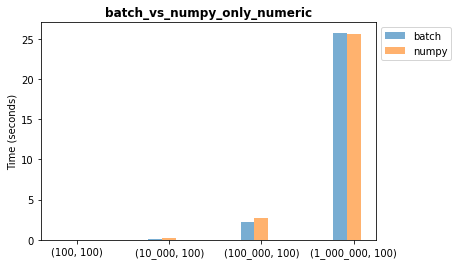

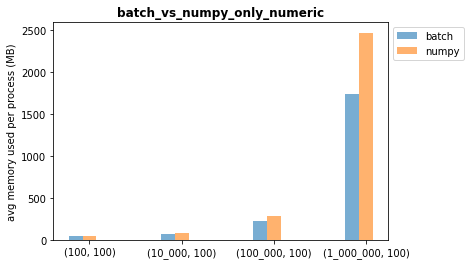

In [42]:
plot_test('/tmp/test1.txt', 'batch_vs_numpy_only_numeric', 'duration', 'Time (seconds)')
 
plot_test('/tmp/memory_test1.txt', 'batch_vs_numpy_only_numeric', 'size', 'avg memory used per process (MB)')


# Performance Tests - 2 (Arrow vs Numpy (forcing Python objects))

In [43]:
def get_sample_data(rows):
    data = [
        np.array([f"sec_{i}" for i in range(rows)]),
        np.random.rand(rows),
        np.random.rand(rows),
        np.array([True if i % 2 == 0 else None for i in range(rows)]),
    ]
    return np.vstack(data)


def get_data_arrow(rows):
    data = get_sample_data(rows)
    arrow_data = []
    for column in data:
        arrow_data.append(pa.array(column))
    return arrow_data


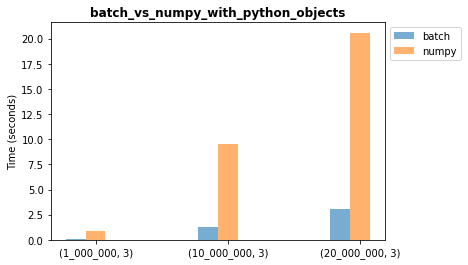

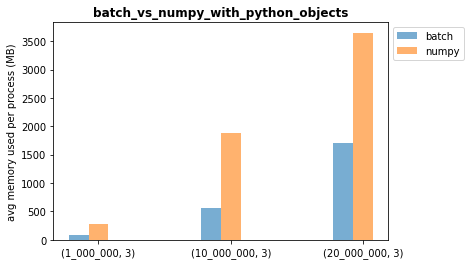

In [44]:
plot_test('/tmp/test2.txt', 'batch_vs_numpy_with_python_objects', 'duration', 'Time (seconds)')
plot_test('/tmp/memory_test2.txt', 'batch_vs_numpy_with_python_objects', 'size', 'avg memory used per process (MB)')


# Performance Tests - 3 (Arrows vs Pandas vs StaticFrame)

In [45]:
def get_sample_data(rows):
    get_bool_array = lambda: np.array(
        [True if i % 2 == 0 else None for i in range(rows)]
    )
    data = pd.DataFrame(
        {
            0: [f"sec_{i}" for i in range(rows)],
            1: np.random.rand(rows),
            2: get_bool_array(),
            **{
                k: (np.random.rand(rows) if k % 2 == 0 else get_bool_array())
                for k in range(200)
            },
        }
    )
    return data

print(get_sample_data(5))

        0     1         2     3         4     5         6     7         8    \
0  0.334550  True  0.048630  True  0.732798  True  0.430509  True  0.776483   
1  0.852346  None  0.769848  None  0.736980  None  0.866753  None  0.629891   
2  0.880409  True  0.084206  True  0.881125  True  0.482738  True  0.736207   
3  0.102571  None  0.426533  None  0.848314  None  0.515922  None  0.454660   
4  0.974159  True  0.305324  True  0.524152  True  0.234713  True  0.930496   

    9    ...       190   191       192   193       194   195       196   197  \
0  True  ...  0.350129  True  0.739282  True  0.269506  True  0.029552  True   
1  None  ...  0.751208  None  0.813527  None  0.164543  None  0.925128  None   
2  True  ...  0.322651  True  0.571179  True  0.018216  True  0.101967  True   
3  None  ...  0.348299  None  0.416276  None  0.227717  None  0.600479  None   
4  True  ...  0.349069  True  0.291792  True  0.132838  True  0.789523  True   

        198   199  
0  0.164281  True  
1  0

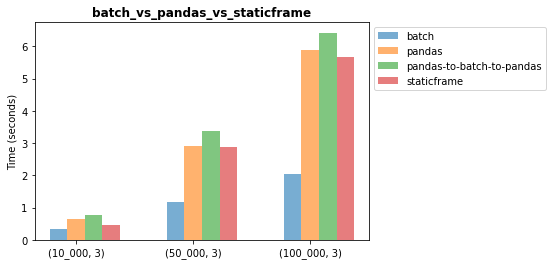

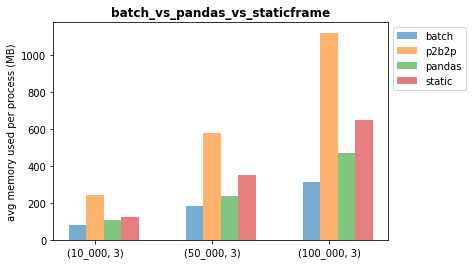

In [46]:
plot_test('/tmp/test3.txt', 'batch_vs_pandas_vs_staticframe', 'duration', 'Time (seconds)')
plot_test('/tmp/memory_test3.txt', 'batch_vs_pandas_vs_staticframe', 'size', 'avg memory used per process (MB)')


# Performance Tests - 4 (Batch vs ArrowFile vs Memory Mapped File)

1. Batch - (default serialization)
2. ArrowFile -  write to Arrow file and then read from arrow file
3. Use memory mapped file.

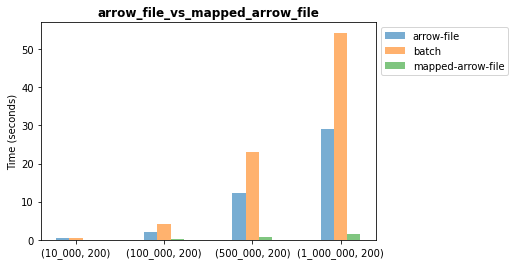

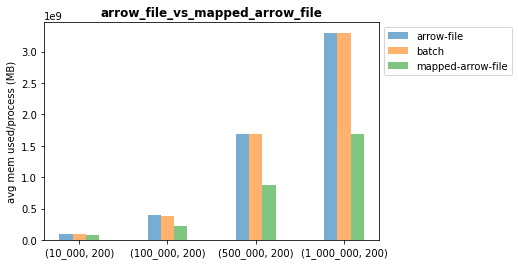

In [47]:
plot_test('/tmp/test4.txt', 'arrow_file_vs_mapped_arrow_file', 'duration', 'Time (seconds)')
plot_test('/tmp/memory_test4.txt', 'arrow_file_vs_mapped_arrow_file', 'size', 'avg mem used/process (MB)')


# Why not just use Apache Arrow

-  Limited support for compute functions
-  StaticFrame/Pandas gives us richer API which Apache Arrow currently does not support
-  Working with lower level constructs could become tedious
-  Probably, we should start build some infrastructure/api around this ?!

# Other Resources (for Performance Metrics)

1. Ray - https://arrow.apache.org/blog/2017/10/15/fast-python-serialization-with-ray-and-arrow/
2. Parquet - - https://stackoverflow.com/questions/48083405/what-are-the-differences-between-feather-and-parquet
3. Flight vs Parquet - https://ursalabs.org/blog/2020-feather-v2/

# Other topics not covered

-  Plasma store (sharing memory across processes)
-  Ray (similar to Plasma, but Python specific) 
-  Parquet and its relationship to Apache arrow

# References

[apache-arrow-java] - (https://www.infoq.com/articles/apache-arrow-java/)

[pyarrow - Official Site] - (https://arrow.apache.org/docs/python/index.html) 
    
[Apache Arrow and the Future of Data Frames" with Wes McKinney (2020)] - (https://www.youtube.com/watch?v=fyj4FyH3XdU)

[Apache Arrow - In Theory and Practice (2020)] - (https://www.youtube.com/watch?v=SFnkSReEjlk) 


[Dremel (some ideas of Apache Arrow from here)]- (https://research.google/pubs/pub36632/)



# Thank You!